In [ ]:
!pip install timm==0.9.2 torchmetrics==0.11.4 einops scikit-learn matplotlib
!pip install opencv-python-headless==4.10.0.84

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/plant_disease_data"
import os
os.makedirs(DATA_DIR, exist_ok=True)

print("Dataset will be stored in:", DATA_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset will be stored in: /content/drive/MyDrive/plant_disease_data


In [ ]:
from google.colab import files
import os, shutil

print("Upload kaggle.json (select the file you downloaded).")
uploaded = files.upload()

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.move("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

print("Kaggle API is now configured.")

Upload kaggle.json (select the file you downloaded).


Saving kaggle.json to kaggle.json
Kaggle API is now configured.


In [ ]:
!kaggle datasets list | head

ref                                                           title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025              Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           5893        121  1.0              
sadiajavedd/students-academic-performance-dataset             Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          11470        288  1.0              
kundanbedmutha/instagram-analytics-dataset                    Instagram Analytics Dataset                            1090208  2025-11-19 09:28:48.650000           1192         29  1.0              
sonalshind

In [ ]:
!kaggle datasets download -d emmarex/plantdisease -p "{DATA_DIR}" -q
print("Downloaded ZIP to:", DATA_DIR)

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
Downloaded ZIP to: /content/drive/MyDrive/plant_disease_data


In [ ]:
import zipfile, os

zip_path = os.path.join(DATA_DIR, "plantdisease.zip")
extract_path = os.path.join(DATA_DIR, "plantvillage")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted dataset to:", extract_path)

Extracted dataset to: /content/drive/MyDrive/plant_disease_data/plantvillage


In [ ]:
base_path = os.path.join(extract_path, "PlantVillage")
classes = sorted(os.listdir(base_path))

print("Number of classes:", len(classes))
print("Sample classes:", classes[:10])

Number of classes: 15
Sample classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']


In [ ]:
import os

BASE_PATH = "/content/drive/MyDrive/plant_disease_data/plantvillage/PlantVillage"

classes = sorted(os.listdir(BASE_PATH))
print("Number of classes:", len(classes))
print("Sample classes:", classes[:10])

Number of classes: 15
Sample classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']


In [ ]:
import glob
import pandas as pd

image_paths = []
labels = []

for cls in classes:
    cls_folder = os.path.join(BASE_PATH, cls)
    for img_path in glob.glob(os.path.join(cls_folder, "*.*")):
        image_paths.append(img_path)
        labels.append(cls)

df = pd.DataFrame({"image": image_paths, "label": labels})

print("Total images:", len(df))
df.head()

Total images: 20638


,image,label
0,/content/drive/MyDrive/plant_disease_data/plan...,Pepper__bell___Bacterial_spot
1,/content/drive/MyDrive/plant_disease_data/plan...,Pepper__bell___Bacterial_spot
2,/content/drive/MyDrive/plant_disease_data/plan...,Pepper__bell___Bacterial_spot
3,/content/drive/MyDrive/plant_disease_data/plan...,Pepper__bell___Bacterial_spot
4,/content/drive/MyDrive/plant_disease_data/plan...,Pepper__bell___Bacterial_spot


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

Train size: 16510
Validation size: 4128


In [ ]:
train_csv_path = "/content/drive/MyDrive/plant_disease_data/train_split.csv"
val_csv_path   = "/content/drive/MyDrive/plant_disease_data/val_split.csv"

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)

print("Saved:")
print(train_csv_path)
print(val_csv_path)

Saved:
/content/drive/MyDrive/plant_disease_data/train_split.csv
/content/drive/MyDrive/plant_disease_data/val_split.csv


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2
import numpy as np
import pandas as pd

In [ ]:
IMG_SIZE = 224

train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image"]
        label = int(self.df.loc[idx, "label_idx"])  # MUST be int

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
class_names = sorted(train_df["label"].unique())
label_to_idx = {cls: i for i, cls in enumerate(class_names)}

train_df["label_idx"] = train_df["label"].map(label_to_idx)
val_df["label_idx"]   = val_df["label"].map(label_to_idx)

In [ ]:
train_dataset = PlantDataset(train_df[["image", "label_idx"]], transform=train_transforms)
val_dataset   = PlantDataset(val_df[["image", "label_idx"]],   transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)

len(train_loader), len(val_loader)

(516, 129)

In [ ]:
imgs, labels = next(iter(train_loader))
print(imgs.shape, labels[:10])

torch.Size([32, 3, 224, 224]) tensor([12,  7, 12, 14,  3,  2,  8,  3,  7, 10])


In [ ]:
import timm
import torch
import torch.nn as nn

num_classes = 38
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "efficientnet_b0"

model = timm.create_model(model_name, pretrained=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
if "efficientnet" in model_name:
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

elif "resnet" in model_name:
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

In [ ]:
model = model.to(device)
print("Model loaded on:", device)

Model loaded on: cuda


In [ ]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

In [ ]:
num_classes = 38

acc_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
f1_metric  = MulticlassF1Score(num_classes=num_classes).to(device)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    acc_metric.reset()
    f1_metric.reset()

    scaler = torch.amp.GradScaler(device)

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        acc_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

    return total_loss / len(loader), acc_metric.compute().item(), f1_metric.compute().item()

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    acc_metric.reset()
    f1_metric.reset()

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            acc_metric.update(outputs, labels)
            f1_metric.update(outputs, labels)

    return total_loss / len(loader), acc_metric.compute().item(), f1_metric.compute().item()

In [ ]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
best_val_loss = float("inf")

epochs_finetune = 15

for epoch in range(1, epochs_finetune + 1):

    print(f"\n===== Fine-Tune Epoch {epoch}/{epochs_finetune} =====")

    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1       = validate(model, val_loader, criterion, device)

    scheduler.step()

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"[Epoch {epoch}] Valid Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/best_model.pt")
        print(f"✔ Saved new best model at Epoch {epoch}")


===== Fine-Tune Epoch 1/15 =====


/tmp/ipython-input-1858235540.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Epoch 1] Train Loss: 0.5063 | Acc: 0.3370 | F1: 0.3437
[Epoch 1] Valid Loss: 0.0563 | Acc: 0.3880 | F1: 0.3853
✔ Saved new best model at Epoch 1

===== Fine-Tune Epoch 2/15 =====
[Epoch 2] Train Loss: 0.0602 | Acc: 0.3871 | F1: 0.3876
[Epoch 2] Valid Loss: 0.0299 | Acc: 0.3911 | F1: 0.3886
✔ Saved new best model at Epoch 2

===== Fine-Tune Epoch 3/15 =====
[Epoch 3] Train Loss: 0.0352 | Acc: 0.3901 | F1: 0.3899
[Epoch 3] Valid Loss: 0.0227 | Acc: 0.3925 | F1: 0.3923
✔ Saved new best model at Epoch 3

===== Fine-Tune Epoch 4/15 =====
[Epoch 4] Train Loss: 0.0257 | Acc: 0.3919 | F1: 0.3918
[Epoch 4] Valid Loss: 0.0202 | Acc: 0.3924 | F1: 0.3918
✔ Saved new best model at Epoch 4

===== Fine-Tune Epoch 5/15 =====
[Epoch 5] Train Loss: 0.0196 | Acc: 0.3924 | F1: 0.3923
[Epoch 5] Valid Loss: 0.0139 | Acc: 0.3931 | F1: 0.3931
✔ Saved new best model at Epoch 5

===== Fine-Tune Epoch 6/15 =====
[Epoch 6] Train Loss: 0.0124 | Acc: 0.3930 | F1: 0.3931
[Epoch 6] Valid Loss: 0.0088 | Acc: 0.3938 |

In [ ]:
model.load_state_dict(torch.load("/content/best_model.pt", map_location=device))
model = model.to(device)
model.eval()

print("Best model loaded for evaluation.")

Best model loaded for evaluation.


In [ ]:
acc_metric.reset()
f1_metric.reset()

criterion = nn.CrossEntropyLoss()

val_loss = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        acc_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

final_acc = acc_metric.compute().item()
final_f1  = f1_metric.compute().item()

print(f"Final Validation Loss: {val_loss/len(val_loader):.4f}")
print(f"Final Validation Accuracy: {final_acc:.4f}")
print(f"Final Validation F1 Score: {final_f1:.4f}")

Final Validation Loss: 0.0065
Final Validation Accuracy: 0.3942
Final Validation F1 Score: 0.3943


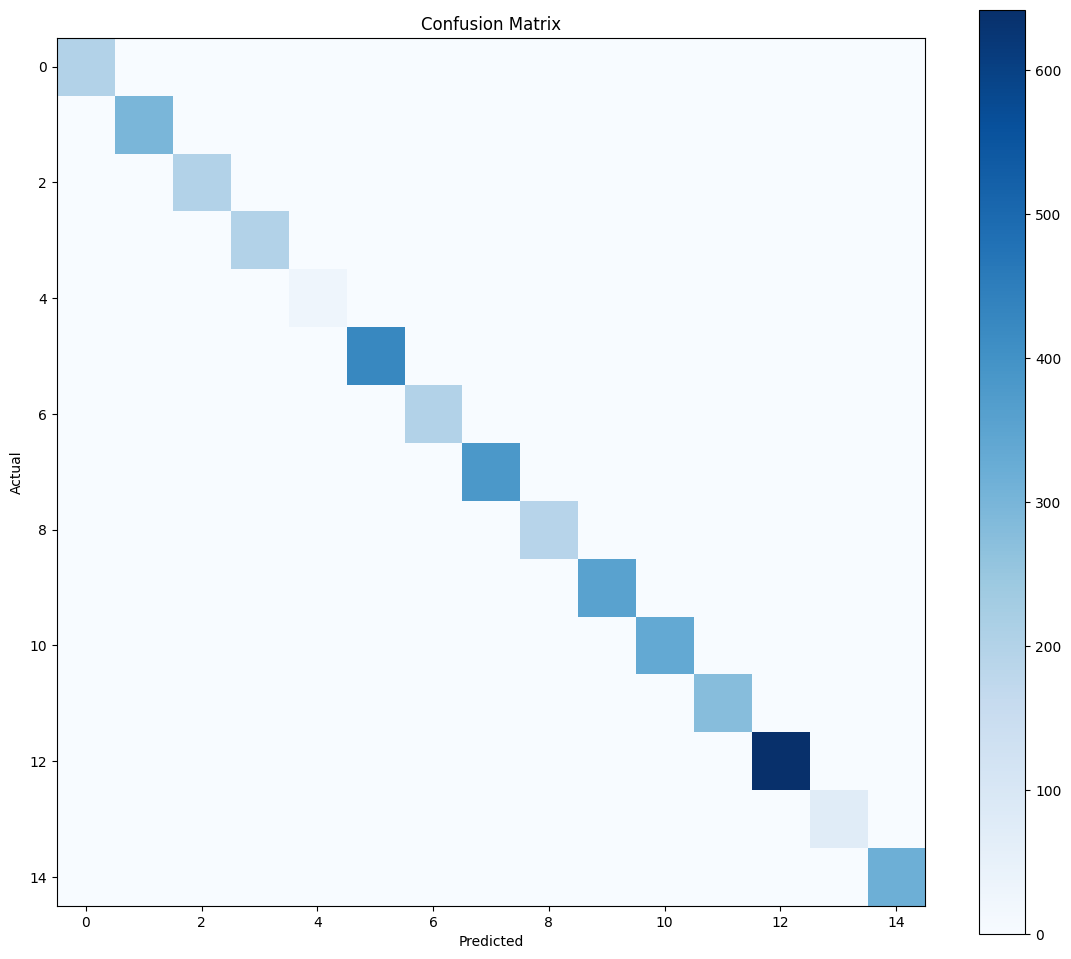

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Per-Class Metrics:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Per-Class Metrics:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       199
                     Pepper__bell___healthy       1.00      1.00      1.00       296
                      Potato___Early_blight       1.00      1.00      1.00       200
                       Potato___Late_blight       1.00      1.00      1.00       200
                           Potato___healthy       1.00      1.00      1.00        30
                      Tomato_Bacterial_spot       1.00      1.00      1.00       426
                        Tomato_Early_blight       0.99      0.99      0.99       200
                         Tomato_Late_blight       0.99      1.00      1.00       382
                           Tomato_Leaf_Mold       1.00      1.00      1.00       190
                  Tomato_Septoria_leaf_spot       1.00      1.00      1.00       354
Tomato_Spider_mites_Two_spotted_spider_mite 

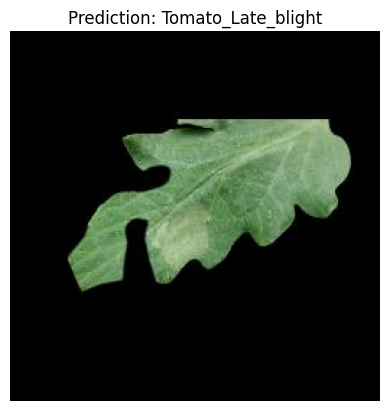

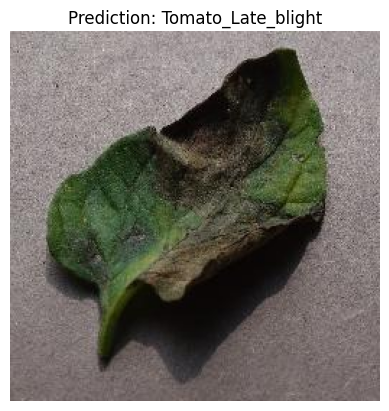

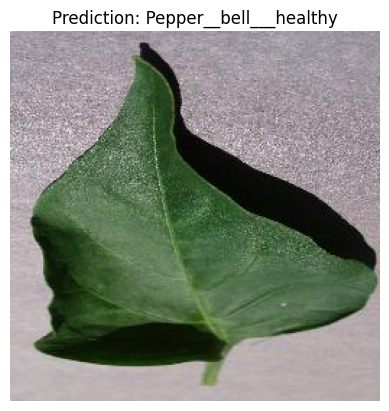

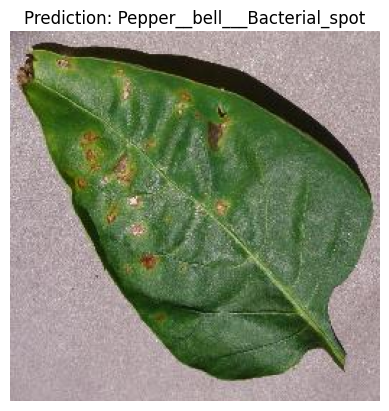

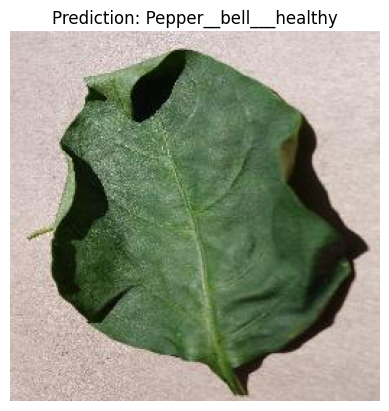

In [ ]:
import random

def predict_image(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    processed = val_transforms(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(processed)
        pred = torch.argmax(output, dim=1).item()

    plt.imshow(img_rgb)
    plt.title(f"Prediction: {class_names[pred]}")
    plt.axis("off")
    plt.show()

sample_paths = random.sample(list(val_df["image"].values), 5)

for path in sample_paths:
    predict_image(path)

In [ ]:
model.blocks[-1]

Sequential(
  (0): InvertedResidual(
    (conv_pw): Conv2d(192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv_dw): Conv2d(1152, 1152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1152, bias=False)
    (bn2): BatchNormAct2d(
      1152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (se): SqueezeExcite(
      (conv_reduce): Conv2d(1152, 48, kernel_size=(1, 1), stride=(1, 1))
      (act1): SiLU(inplace=True)
      (conv_expand): Conv2d(48, 1152, kernel_size=(1, 1), stride=(1, 1))
      (gate): Sigmoid()
    )
    (conv_pwl): Conv2d(1152, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNormAct2d(
      320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
  

In [ ]:
import torch.nn as nn

def find_last_conv_layer(model):
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module
    return last_conv

target_layer = find_last_conv_layer(model)
print("Selected target layer:", target_layer)


feature_maps = None
gradients = None

def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

print("Grad-CAM hooks registered.")


Selected target layer: Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
Grad-CAM hooks registered.


In [ ]:
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt

def generate_gradcam(img_path, model, class_names):
    model.eval()

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img_rgb.copy()

    tensor = val_transforms(img_rgb).unsqueeze(0).to(device)

    output = model(tensor)
    pred_class = torch.argmax(output, dim=1).item()

    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    fmap = feature_maps[0].detach().cpu().numpy()      # (C, H, W)
    grads = gradients[0].detach().cpu().numpy()        # (C, H, W)

    weights = np.mean(grads, axis=(1, 2))              # (C,)

    cam = np.zeros(fmap.shape[1:], dtype=np.float32)   # (H, W)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0)

    cam -= cam.min()
    cam /= cam.max()

    cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = (0.4 * heatmap + 0.6 * orig_img).astype(np.uint8)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay\nPredicted: {class_names[pred_class]}")
    plt.axis("off")

    plt.show()


Image: /content/drive/MyDrive/plant_disease_data/plantvillage/PlantVillage/Pepper__bell___healthy/cbdca8a1-7822-472a-bc6f-a67a7a142dc0___JR_HL 8768.JPG


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


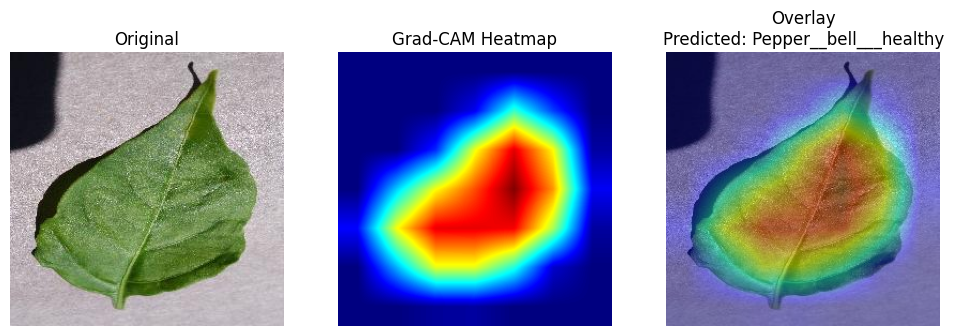


Image: /content/drive/MyDrive/plant_disease_data/plantvillage/PlantVillage/Tomato_Bacterial_spot/d60ef655-b54e-4e58-ab25-64f523a97694___GCREC_Bact.Sp 3336.JPG


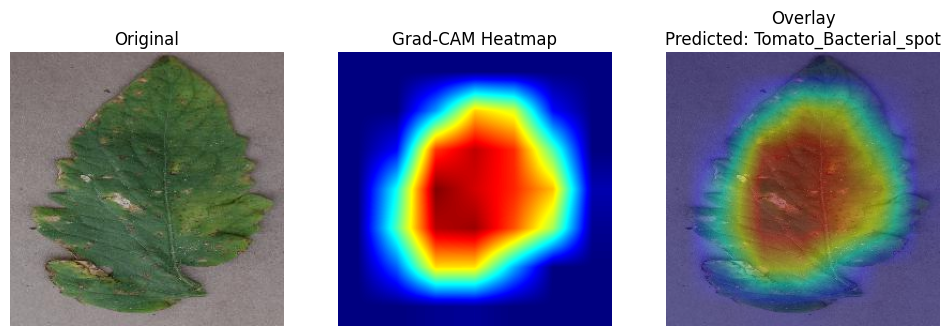


Image: /content/drive/MyDrive/plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0ec3e86a-8c2a-4f66-9c29-ee995dc88a7e___UF.GRC_YLCV_Lab 02980.JPG


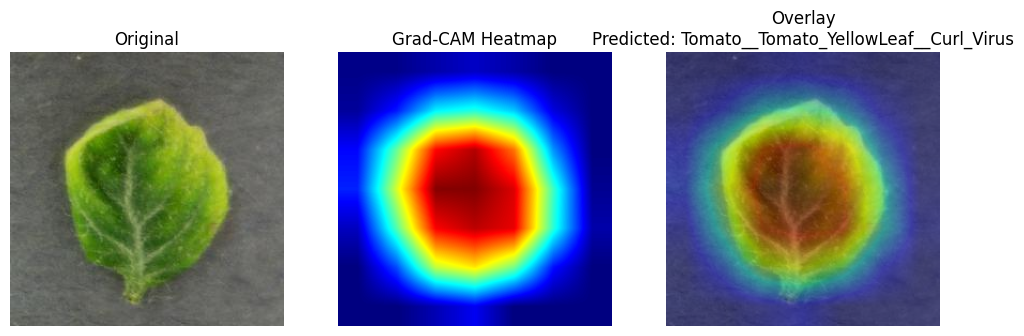


Image: /content/drive/MyDrive/plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_mosaic_virus/a142b58c-1713-4e17-a68c-96eaf4b5ae23___PSU_CG 2219.JPG


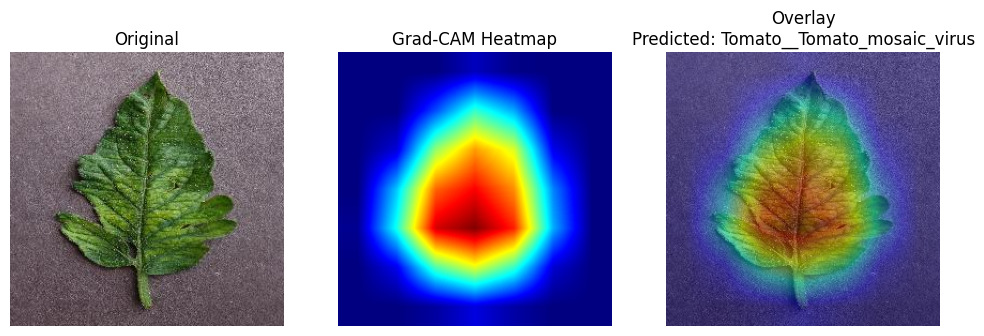


Image: /content/drive/MyDrive/plant_disease_data/plantvillage/PlantVillage/Tomato_Bacterial_spot/a0be793f-3831-4101-9142-69986edb313e___UF.GRC_BS_Lab Leaf 0801.JPG


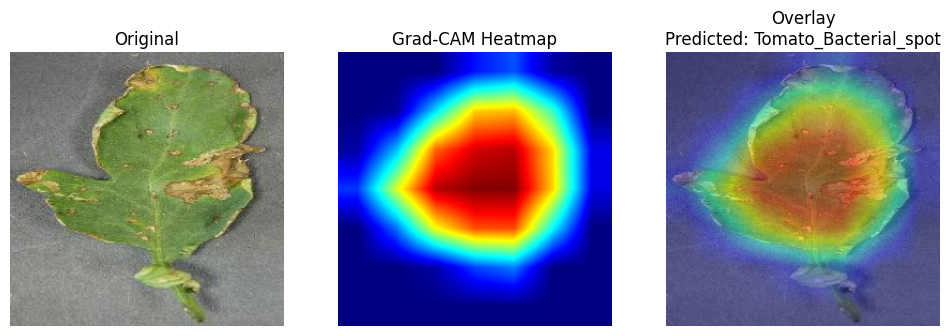

In [ ]:
import random

sample_paths = random.sample(list(val_df["image"].values), 5)

for p in sample_paths:
    print("\nImage:", p)
    generate_gradcam(p, model, class_names)

In [ ]:
import shutil

drive_model_path = "/content/drive/MyDrive/plant_disease_project/best_model.pt"
os.makedirs("/content/drive/MyDrive/plant_disease_project", exist_ok=True)

shutil.copy("/content/best_model.pt", drive_model_path)

print("Model saved to:", drive_model_path)

Model saved to: /content/drive/MyDrive/plant_disease_project/best_model.pt


In [ ]:
from google.colab import files

print("Downloading best_model.pt ...")
files.download("/content/best_model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import matplotlib.pyplot as plt

os.makedirs("/content/gradcam_samples", exist_ok=True)

for i, path in enumerate(sample_paths):
    img = cv2.imread(path)
    cv2.imwrite(f"/content/gradcam_samples/sample_{i}.jpg", img)

shutil.make_archive("/content/gradcam_outputs", 'zip', "/content/gradcam_samples")

files.download("/content/gradcam_outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

label_map = {
    "label_to_idx": label_to_idx,
    "idx_to_label": {v: k for k, v in label_to_idx.items()}
}

with open("/content/label_mapping.json", "w") as f:
    json.dump(label_map, f, indent=4)

files.download("/content/label_mapping.json")

print(label_map)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'label_to_idx': {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}, 'idx_to_label': {0: 'Pepper__bell___Bacterial_spot', 1: 'Pepper__bell___healthy', 2: 'Potato___Early_blight', 3: 'Potato___Late_blight', 4: 'Potato___healthy', 5: 'Tomato_Bacterial_spot', 6: 'Tomato_Early_blight', 7: 'Tomato_Late_blight', 8: 'Tomato_Leaf_Mold', 9: 'Tomato_Septoria_leaf_spot', 10: 'Tomato_Spider_mites_Two_spotted_spider_mite', 11: 'Tomato__Target_Spot', 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus', 13: 'Tomato__Tomato_mosaic_virus', 14: 'Tomato_healthy'}}


In [ ]:
disease_info = {
    cls: {
        "remedy": "Add remedy here.",
        "fertilizer": "Add fertilizer advice here.",
        "watering": "Add watering advice here."
    }
    for cls in class_names
}

with open("/content/disease_info.json", "w") as f:
    json.dump(disease_info, f, indent=4)

files.download("/content/disease_info.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gradcam_code = """
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_gradcam(model, img_rgb, device, target_layer, val_transforms):
    model.eval()

    orig_img = img_rgb.copy()
    tensor = val_transforms(img_rgb).unsqueeze(0).to(device)

    feature_maps = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)

    output = model(tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, pred_class].backward()

    handle_f.remove()
    handle_b.remove()

    fmap = feature_maps[0].detach().cpu().numpy()
    grads = gradients[0].detach().cpu().numpy()

    weights = np.mean(grads, axis=(1, 2))
    cam = np.maximum(np.sum(weights[:, None, None] * fmap, axis=0), 0)

    cam -= cam.min()
    cam /= cam.max()
    cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.4 * heatmap + 0.6 * orig_img).astype(np.uint8)

    return overlay, pred_class
"""

with open("/content/gradcam.py", "w") as f:
    f.write(gradcam_code)

files.download("/content/gradcam.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>